In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("flipkart_product_cleaned_final_sentiment.csv")

In [3]:
df.head()

,ProductName,Price,Rate,Review,Summary,sentiment
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999,1,super !,great cooler excel air flow price amaz unbelie...,0.650000
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999,1,awesom,best budget fit cooler nice cool,0.587500
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999,1,fair,qualiti good power air decent,0.433333
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999,0,useless product,bad product fan,-0.700000
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3999,1,fair,ok ok product,0.500000


In [4]:
d=dict(zip(df['Summary'], df['Rate']))
list(d.items())[0:10]

[('great cooler excel air flow price amaz unbelievablejust love', 1),
 ('best budget fit cooler nice cool', 1),
 ('qualiti good power air decent', 1),
 ('bad product fan', 0),
 ('ok ok product', 1),
 ('cooler realli fantast provid good air flow highli recommend', 1),
 ('good product', 1),
 ('nice', 1),
 ('bad cooler', 0),
 ('good', 1)]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [6]:
df['Summary'] = df['Summary'].fillna('')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df['Summary'], df['Rate'], test_size=0.2, random_state=7)

In [8]:
# Convert text data to TF-IDF features for traditional ML models
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [9]:
# Train a Logistic Regression model as an example of a traditional ML model
log_reg_model = LogisticRegression(penalty='l2',
    random_state=7,
    solver='saga',
    max_iter=100,
    multi_class='auto',
    verbose=0)
log_reg_model.fit(x_train_tfidf, y_train)

LogisticRegression(random_state=7, solver='saga')

In [10]:
# Predict and evaluate the Logistic Regression model
y_pred = log_reg_model.predict(x_test_tfidf)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}')

Logistic Regression Accuracy: 0.9274005393449081
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.65      0.74      5134
           1       0.94      0.98      0.96     27869

    accuracy                           0.93     33003
   macro avg       0.89      0.82      0.85     33003
weighted avg       0.92      0.93      0.92     33003

Confusion Matrix:
[[ 3356  1778]
 [  618 27251]]


In [11]:
# Tokenize and pad sequences for LSTM
max_words = 5000
max_len = 100

In [12]:
tokenizer = Tokenizer(num_words=max_words)  # Tokenizer(num_words=max_words): Creates a tokenizer object that keeps the top max_words (5000) most frequent words in the training data.
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)  # pad_sequences(x_train_seq, maxlen=max_len): Pads each sequence to ensure that all sequences in x_train_seq have the same length (max_len = 100). If a sequence is shorter than max_len, it is padded with zeros.
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

In [13]:
# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),Dropout(0.5), # LSTM(64, return_sequences=True): First LSTM layer with 64 units. return_sequences=True means that it returns the full sequence of outputs for each input (required for stacking another LSTM layer on top).
                                                  # LSTM(64): Second LSTM layer with 64 units. This time return_sequences is not specified, so it returns only the last output in the output sequence.
    LSTM(64),Dropout(0.5), # Dropout(0.5): Applies dropout to the layer's output. Dropout rate is 0.5, meaning 50% of the neurons will be randomly set to zero during training to prevent overfitting.
    Dense(1, activation='sigmoid') # Dense(1, activation='sigmoid'): A dense (fully connected) layer with a single neuron. The sigmoid activation function outputs a value between 0 and 1, suitable for binary classification.
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\ritik\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Train the LSTM model
lstm_model.fit(x_train_pad, y_train, epochs=3, batch_size=32, validation_split=0.2)

Epoch 1/3
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 404s 120ms/step - accuracy: 0.9130 - loss: 0.2430 - val_accuracy: 0.9328 - val_loss: 0.1826
Epoch 2/3
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 389s 118ms/step - accuracy: 0.9403 - loss: 0.1698 - val_accuracy: 0.9343 - val_loss: 0.1834
Epoch 3/3
3301/3301 ━━━━━━━━━━━━━━━━━━━━ 374s 113ms/step - accuracy: 0.9452 - loss: 0.1571 - val_accuracy: 0.9357 - val_loss: 0.1804


In [15]:
# Evaluate the LSTM model
lstm_y_pred = (lstm_model.predict(x_test_pad) > 0.5).astype("int32")
print(f'LSTM Accuracy: {accuracy_score(y_test, lstm_y_pred)}')
print(f'Classification Report:\n{classification_report(y_test, lstm_y_pred)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, lstm_y_pred)}')

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step
LSTM Accuracy: 0.9337635972487349
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      5134
           1       0.95      0.97      0.96     27869

    accuracy                           0.93     33003
   macro avg       0.89      0.84      0.87     33003
weighted avg       0.93      0.93      0.93     33003

Confusion Matrix:
[[ 3676  1458]
 [  728 27141]]


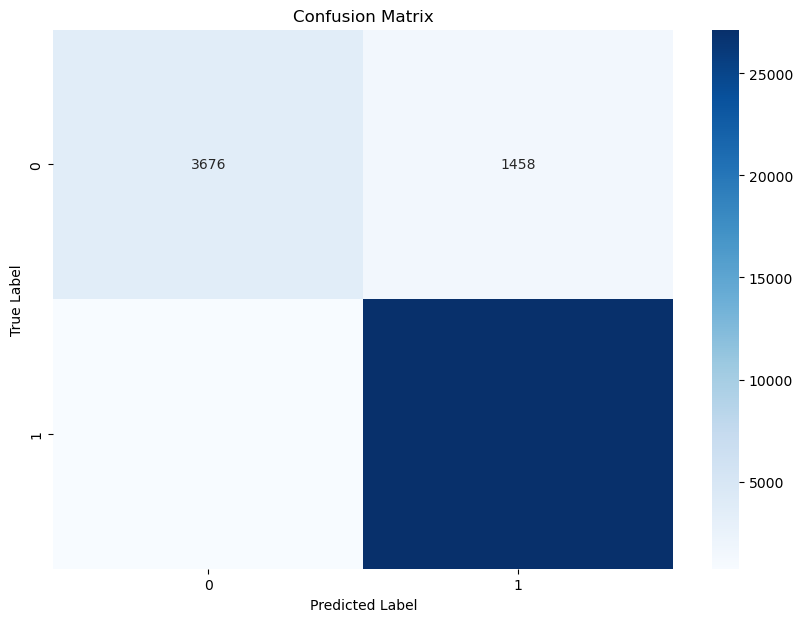

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, lstm_y_pred)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()